In [0]:
import pandas as pd
import numpy as np


In [2]:
url = 'https://raw.githubusercontent.com/salma71/MSDS_SU2020/master/Recommender_system612/week_1/ratings.csv'
movie = pd.read_csv(url, na_values=np.nan)
display(movie.head())

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [3]:
url_title = 'https://raw.githubusercontent.com/salma71/MSDS_SU2020/master/Recommender_system612/week_1/movies.csv'
title = pd.read_csv(url_title, na_values=np.nan)
display(title.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df = pd.merge(movie, title, on='movieId')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,307,3.5,1256677221,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
1,6,307,4.0,832059248,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
2,56,307,4.0,1383625728,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,71,307,5.0,1257795414,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
4,84,307,3.0,999055519,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama


Let’s look at what each column represents:

*   userId: the ID of the user who rated the movie.
*   itemId: the ID of the movie.
* rating - The rating the user gave the movie, between 1 and 5.
* timestamp - The time the movie was rated.
* title - The title of the movie.

In [5]:
df.describe()

,userId,movieId,rating,timestamp
count,65326.000000,65326.000000,65326.000000,6.532600e+04
mean,322.875501,17712.205186,3.463774,1.182468e+09
std,184.641120,34857.156294,1.135693,2.143795e+08
min,1.000000,1.000000,0.500000,8.288924e+08
25%,173.000000,1088.000000,3.000000,9.923211e+08
50%,319.000000,2571.000000,3.500000,1.147048e+09
75%,486.000000,6539.000000,4.000000,1.391471e+09
max,653.000000,192225.000000,5.000000,1.537717e+09


In [6]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'71 (2014),3.0
'Hellboy': The Seeds of Creation (2004),3.0
'Round Midnight (1986),4.5
'Salem's Lot (2004),3.5
'Til There Was You (1997),4.0


Next we would like to see the number of ratings for each movie. We do this by creating a number_of_ratings column. This is important so that we can see the relationship between the average rating of a movie and the number of ratings the movie got. It is very possible that a 5 star movie was rated by just one person. It is therefore statistically incorrect to classify that movie has a 5 star movie. We will therefore need to set a threshold for the minimum number of ratings as we build the recommender system. In order to create this new column we use pandas groupby utility. We group by the title column and then use the count function to calculate the number of ratings each movie got. Afterwards we view the new dataframe by using the head() function.

In [7]:
ratings['number_of_ratings'] = df.groupby('title')['rating'].count()
ratings.head()

,rating,number_of_ratings
title,,
'71 (2014),3.0,1
'Hellboy': The Seeds of Creation (2004),3.0,1
'Round Midnight (1986),4.5,1
'Salem's Lot (2004),3.5,1
'Til There Was You (1997),4.0,1


Let’s now plot a Histogram using pandas plotting functionality to visualize the distribution of the ratings

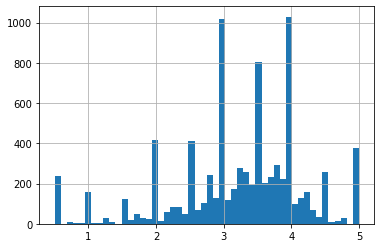

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
ratings['rating'].hist(bins=50)

We can see that most of the movies are rated between 2.5 and 4. Next let’s visualize the number_of_ratings column in as similar manner.

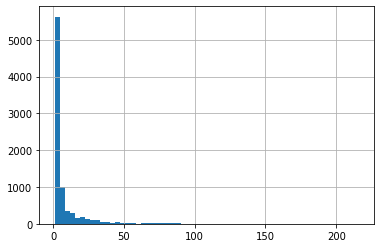

In [9]:
ratings['number_of_ratings'].hist(bins=60)

From the above histogram it is clear that most movies have few ratings. Movies with most ratings are those that are most famous.
Let’s now check the relationship between the rating of a movie and the number of ratings. We do this by plotting a scatter plot using seaborn. Seaborn enables us to do this using the `jointplot()` function.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


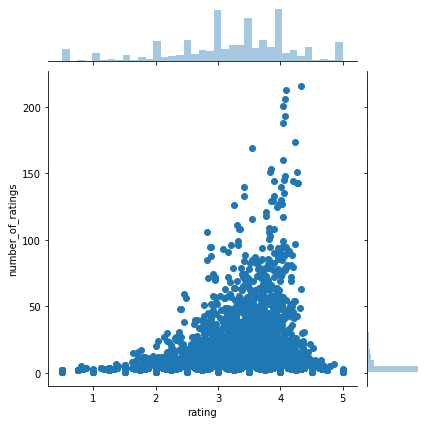

In [10]:
import seaborn as sns
sns.jointplot(x='rating', y='number_of_ratings', data=ratings)

From the diagram we can see that their is a positive relationship between the average rating of a movie and the number of ratings. The graph indicates that the more the ratings a movie gets the higher the average rating it gets. This is important to note especially when choosing the threshold for the number of ratings per movie.

Let’s now move on swiftly and create a simple item based recommender system. In order to do this we need to convert our dataset into a matrix with the movie titles as the columns, the user_id as the index and the ratings as the values. By doing this we shall get a dataframe with the columns as the movie titles and the rows as the user ids. Each column represents all the ratings of a movie by all users. The rating appear as NAN where a user didn't rate a certain movie. We shall use this matrix to compute the correlation between the ratings of a single movie and the rest of the movies in the matrix. We use pandas pivot_table utility to create the movie matrix.

In [11]:
movie_matrix = df.pivot_table(index='userId', columns='title', values='rating')
movie_matrix.shape
# movie_matrix = movie_matrix.fillna(0)
# movie_matrix = movie_matrix.dropna(axis=1, how='all')
display(movie_matrix.head())
print(movie_matrix.isnull().all().sum())

# print(movie_matrix.shape[0] - movie_matrix.dropna(how='all').shape[0])

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And God Spoke (1993),...And Justice for All (1979),1-900 (06) (1994),10 (1979),10 Cloverfield Lane (2016),10 Rillington Place (1971),10 Things I Hate About You (1999),"10,000 BC (2008)",100 Girls (2000),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),"10th Victim, The (La decima vittima) (1965)",11.22.63 (2016),11:14 (2003),"11th Hour, The (2007)",12 (2007),12 Angry Men (1957),12 Chairs (1971),12 Chairs (1976),12 Years a Slave (2013),127 Hours (2010),12:08 East of Bucharest (A fost sau n-a fost?) (2006),13 (2010),13 Assassins (Jûsan-nin no shikaku) (2010),13 Ghosts (1960),13 Going on 30 (2004),13 Hours (2016),13 Sins (2014),...,Zachariah (1971),Zack and Miri Make a Porno (2008),Zapped (2014),Zapped! (1982),Zardoz (1974),Zathura (2005),"Zed & Two Noughts, A (1985)",Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelig (1983),Zero Dark Thirty (2012),Zero Day (2002),Zero Effect (1998),"Zero Theorem, The (2013)",Zeus and Roxanne (1997),"Zidane: A 21st Century Portrait (Zidane, un portrait du 21e siècle) (2006)",Zift (2008),Ziggy Stardust and the Spiders from Mars (1973),Zodiac (2007),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombieland (2009),Zombies! Zombies! Zombies! (2008),Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zootopia (2016),"Zorro, the Gay Blade (1981)",Zulu (1964),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),Сердца трех (1992),チェブラーシカ (2010)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,3.5,NaN,3.0,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0


Next let’s look at the most rated items and choose two of them to work with in this simple recommender system. We use pandas sort_values utility and set ascending to false in order to arrange the items from the most rated. We then use the head() function to view the top 10.

In [12]:
ratings.sort_values('number_of_ratings', ascending=False).head(10)

,rating,number_of_ratings
title,,
"Shawshank Redemption, The (1994)",4.333333,216
Pulp Fiction (1994),4.084507,213
Forrest Gump (1994),4.080097,206
"Silence of the Lambs, The (1991)",4.047264,201
"Matrix, The (1999)",4.077720,193
Star Wars: Episode IV - A New Hope (1977),4.042553,188
Schindler's List (1993),4.238506,174
Jurassic Park (1993),3.550296,169
Braveheart (1995),4.046875,160


In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(movie_matrix, test_size=0.2, random_state = 42)
train=pd.DataFrame(train)
test=pd.DataFrame(test)

In [14]:
# msk = np.random.rand(len(movie_matrix)) < 0.8
# train = movie_matrix[msk]
# test = movie_matrix[~msk]
print(len(test))
print(len(train))

131
522


In [15]:
print(train.isnull().all(axis=1).sum())
train = train.dropna(axis=1, how='all')
train
print(train.isna().all(axis=1).sum())


0
0


In [16]:
raw_avg = movie_matrix.stack().mean(skipna=True)
raw_avg 

3.463787639881818

In [17]:
train_er = raw_avg - train
train_er.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),1-900 (06) (1994),10 Cloverfield Lane (2016),10 Rillington Place (1971),10 Things I Hate About You (1999),"10,000 BC (2008)",100 Girls (2000),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),102 Dalmatians (2000),11.22.63 (2016),11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Chairs (1971),12 Chairs (1976),12 Years a Slave (2013),127 Hours (2010),13 (2010),13 Assassins (Jûsan-nin no shikaku) (2010),13 Going on 30 (2004),13 Hours (2016),13 Sins (2014),"13th Warrior, The (1999)",1408 (2007),15 Minutes (2001),16 Blocks (2006),17 Again (2009),1776 (1972),187 (One Eight Seven) (1997),1900 (Novecento) (1976),...,Young Sherlock Holmes (1985),"Young Victoria, The (2009)",Young and Innocent (1937),"Young and the Damned, The (Olvidados, Los) (1950)",Youngblood (1986),Your Friends and Neighbors (1998),Your Highness (2011),Your Name. (2016),"Yours, Mine and Ours (1968)",Z (1969),Zack and Miri Make a Porno (2008),Zapped! (1982),Zathura (2005),"Zed & Two Noughts, A (1985)",Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelig (1983),Zero Dark Thirty (2012),Zero Day (2002),Zero Effect (1998),Zeus and Roxanne (1997),Zift (2008),Ziggy Stardust and the Spiders from Mars (1973),Zodiac (2007),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombieland (2009),Zookeeper (2011),Zoolander (2001),Zootopia (2016),Zulu (1964),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),チェブラーシカ (2010)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.463788,NaN,NaN
211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
train_rmse = ((train_er ** 2).stack().mean(skipna=True))**0.5
train_rmse

1.1047558106340873

In [19]:
test_er = raw_avg - test
test_rmse = ((test_er ** 2).stack().mean(skipna=True))**0.5
test_rmse

1.2184933841435843

 Using training data, let’s calculate the bias for each user and each item.

In [0]:
def get_bias_matrix(df, df_mean, raw_average, name):
  bias = pd.DataFrame(df_mean - raw_average)
  bias = bias.rename(columns={0: name})
  return(bias)

In [21]:
user_mean = train.mean(axis=1, skipna=True, numeric_only=True)
user_bias = get_bias_matrix(train, user_mean, raw_average=raw_avg, name ='userBias')
user_bias

,userBias
userId,
594,-0.783788
406,0.345736
30,0.212683
287,-0.045606
211,0.679070
...,...
72,0.793196
107,0.095036
271,0.473712


In [22]:
movie_mean = train.mean(axis=0, skipna=True, numeric_only=True)
movie_bias = get_bias_matrix(train, movie_mean, raw_average=raw_avg, name ='movieBias')
movie_bias

,movieBias
title,
'71 (2014),-0.463788
'Hellboy': The Seeds of Creation (2004),-0.463788
'Round Midnight (1986),1.036212
'Til There Was You (1997),0.536212
"'burbs, The (1989)",-0.320930
...,...
xXx (2002),-1.079172
xXx: State of the Union (2005),-1.463788
¡Three Amigos! (1986),-0.095367


Calculating the baseline predictors for every user-item combination for train and test datasets.

In [0]:
def get_baseline(df, raw_average, bias_1, bias_2):
  for key, value in df.iteritems():
    for i, val in df[key].iteritems():
      df[key][i] = raw_average + bias_1['userBias'][i] + bias_2['movieBias'][i]

  return(df)

In [24]:
base_line_train = get_baseline(train, raw_average=raw_avg, bias_1=user_bias, bias_2=movie_bias)
base_line_train

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),1-900 (06) (1994),10 Cloverfield Lane (2016),10 Rillington Place (1971),10 Things I Hate About You (1999),"10,000 BC (2008)",100 Girls (2000),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),102 Dalmatians (2000),11.22.63 (2016),11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Chairs (1971),12 Chairs (1976),12 Years a Slave (2013),127 Hours (2010),13 (2010),13 Assassins (Jûsan-nin no shikaku) (2010),13 Going on 30 (2004),13 Hours (2016),13 Sins (2014),"13th Warrior, The (1999)",1408 (2007),15 Minutes (2001),16 Blocks (2006),17 Again (2009),1776 (1972),187 (One Eight Seven) (1997),1900 (Novecento) (1976),...,Young Sherlock Holmes (1985),"Young Victoria, The (2009)",Young and Innocent (1937),"Young and the Damned, The (Olvidados, Los) (1950)",Youngblood (1986),Your Friends and Neighbors (1998),Your Highness (2011),Your Name. (2016),"Yours, Mine and Ours (1968)",Z (1969),Zack and Miri Make a Porno (2008),Zapped! (1982),Zathura (2005),"Zed & Two Noughts, A (1985)",Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelig (1983),Zero Dark Thirty (2012),Zero Day (2002),Zero Effect (1998),Zeus and Roxanne (1997),Zift (2008),Ziggy Stardust and the Spiders from Mars (1973),Zodiac (2007),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombieland (2009),Zookeeper (2011),Zoolander (2001),Zootopia (2016),Zulu (1964),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),チェブラーシカ (2010)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
594,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,...,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879,2.382879
406,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,...,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736,2.720736
30,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,...,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.712683,3.7126

Baseline predictor for the test data

In [32]:
print(test.isnull().all(axis=0).sum())
test = test.dropna(how='all', axis=0)
movie_mean_t = test.mean(axis=0, skipna=True)
movie_bias_t = get_bias_matrix(test, movie_mean_t, raw_average=raw_avg, name ='movieBias')
movie_bias_t
# print(test.isnull().all(axis=0).sum())


0


,movieBias
title,
'71 (2014),-0.384211
'Hellboy': The Seeds of Creation (2004),-0.384211
'Round Midnight (1986),-0.384211
'Salem's Lot (2004),-0.384211
'Til There Was You (1997),-0.384211
...,...
xXx: State of the Union (2005),-0.384211
¡Three Amigos! (1986),-0.384211
À nous la liberté (Freedom for Us) (1931),-0.384211


In [26]:

user_mean_t = test.mean(axis=1, skipna=True)
user_bias_t = get_bias_matrix(test, user_mean_t, raw_average=raw_avg, name ='userBias')
user_bias_t

,userBias
userId,
110,-0.776288
275,0.390379
200,0.348712
430,0.430949
448,0.313990
...,...
221,-0.078073
421,0.929731
382,-0.186010


In [33]:
base_line_test = get_baseline(test, raw_average=raw_avg, bias_1=user_bias_t, bias_2=movie_bias_t)
base_line_test.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And God Spoke (1993),...And Justice for All (1979),1-900 (06) (1994),10 (1979),10 Cloverfield Lane (2016),10 Rillington Place (1971),10 Things I Hate About You (1999),"10,000 BC (2008)",100 Girls (2000),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),"10th Victim, The (La decima vittima) (1965)",11.22.63 (2016),11:14 (2003),"11th Hour, The (2007)",12 (2007),12 Angry Men (1957),12 Chairs (1971),12 Chairs (1976),12 Years a Slave (2013),127 Hours (2010),12:08 East of Bucharest (A fost sau n-a fost?) (2006),13 (2010),13 Assassins (Jûsan-nin no shikaku) (2010),13 Ghosts (1960),13 Going on 30 (2004),13 Hours (2016),13 Sins (2014),...,Zachariah (1971),Zack and Miri Make a Porno (2008),Zapped (2014),Zapped! (1982),Zardoz (1974),Zathura (2005),"Zed & Two Noughts, A (1985)",Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelig (1983),Zero Dark Thirty (2012),Zero Day (2002),Zero Effect (1998),"Zero Theorem, The (2013)",Zeus and Roxanne (1997),"Zidane: A 21st Century Portrait (Zidane, un portrait du 21e siècle) (2006)",Zift (2008),Ziggy Stardust and the Spiders from Mars (1973),Zodiac (2007),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombieland (2009),Zombies! Zombies! Zombies! (2008),Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zootopia (2016),"Zorro, the Gay Blade (1981)",Zulu (1964),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),Сердца трех (1992),チェブラーシカ (2010)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
275,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,...,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956,3.469956
200,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,...,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289,3.428289
448,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,...,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567,3.393567

Calculating the RMSE for the baseline predictors for both training data and test data.

In [34]:
baseline_er_tr = raw_avg - base_line_train
baseline_er_tr.head()
baseline_rmse_tr = ((baseline_er_tr ** 2).stack().mean(skipna=True))**0.5
baseline_rmse_tr - train_rmse

-0.036690461259314855

In [35]:
baseline_er_ts = raw_avg - base_line_test
baseline_er_ts.head()
baseline_rmse_ts = ((baseline_er_ts ** 2).stack().mean(skipna=True))**0.5
baseline_rmse_ts - test_rmse

-0.5602341071571414